
Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [608]:
# Импорт необходмых библиотек
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.utils import shuffle

import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
random_state = 12345
sns.set()

In [609]:
data = pd.read_csv('/datasets/Churn.csv')

In [610]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [611]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


1. Удалим столбцы `RowNumber `, `CustomerId` и `Surname`, т.к. не думаю, что фамилия, id клиента или порядковый номер влияет на отток.
2. В столбце `Tenure` присутствуют пропуски, необходимо обработать 
3. Разделим признаки и выделим категориальные и количественные данные
4. К категориальным данным применим OHE, т.к. техника универсальная и подходит для всех алгоритмов обучения
5. Количественные данные отмасштабируем, т.к. если этого не сделать - например, баланс на счёте будет иметь больший вес, чем возраст

## 1.1 Удаление неиформативных столбцов

In [612]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## 1.2 Обработка пропусков

Думаю, стоит сделать так: Выделить возрастные группы по 10 лет, далее посмотреть на распределение пропусков по возрастным группам и посмотреть на сводную таблицу с медианным значением столбца `Tenure` для каждой возрастной группы

In [613]:
data['age_group'] = data['Age']//10

3    424
4    232
2    131
5     83
6     26
7      9
1      3
9      1
Name: age_group, dtype: int64


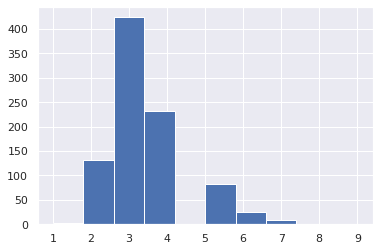

In [614]:
print(data[data['Tenure'].isna()]['age_group'].value_counts())
data[data['Tenure'].isna()]['age_group'].hist()

In [615]:
data.pivot_table(index=['age_group'], values='Tenure', aggfunc='median')

,Tenure
age_group,
1,5.0
2,5.0
3,5.0
4,5.0
5,5.0
6,5.0
7,5.0
8,6.0
9,1.0


Видно, что практически все пропуски приходятся на возрастные группы 2-7, при этом у каждой группы одинаковое мединное значение , поэтому, думаю есть смысл заполнить все пропуски медаинным значением и избавимся от доп. столбца `age_group`

In [616]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data = data.drop('age_group', axis=1)

In [617]:
# Убедимся, что пропусков не осталось
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.3 Разеделение на признаки и целевую переемнную. Выделение категориальных и количественных признаков

In [618]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [619]:
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [620]:
# Разеделение на признаки и  целевую переменную 

In [621]:
X = data.drop('Exited', axis=1)
target = data['Exited']

In [622]:
# Выделим свисок всех столцов
columns = X.columns
columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [623]:
# Категориальные признаки
cat_col = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [624]:
# Количественные признаки
num_col = columns.drop(cat_col)
num_col

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')

## 1.4 Применение OHE

In [625]:
features_ohe = pd.get_dummies(X[cat_col], drop_first=True)
features_ohe.shape

(10000, 5)

## 1.5 Масштабирование количественных признаков

In [626]:
scaler = StandardScaler()
scaler.fit(X[num_col])
features_scaler = pd.DataFrame(scaler.transform(X[num_col]), columns=num_col)
features_scaler.shape

(10000, 6)

In [627]:
features = features_ohe.join(features_scaler)

In [628]:
features.head()

,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,1,1,0,0,0,-0.326221,0.293517,-1.086246,-1.225848,-0.911583,0.021886
1,0,1,0,1,0,-0.440036,0.198164,-1.448581,0.117350,-0.911583,0.216534
2,1,0,0,0,0,-1.536794,0.293517,1.087768,1.333053,2.527057,0.240687
3,0,0,0,0,0,0.501521,0.007457,-1.448581,-1.225848,0.807737,-0.108918
4,1,1,0,1,0,2.063884,0.388871,-1.086246,0.785728,-0.911583,-0.365276


# 2. Исследование задачи

Дисбаланс классов в 3.9 раза


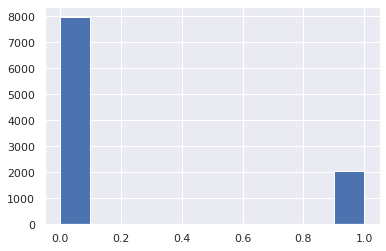

In [629]:
# Проверим дисбаланс классов
target_zeros = target[target == 0]
target_ones = target[target == 1]
target.hist()
print("Дисбаланс классов в {} раза".format(round(len(target_zeros)/len(target_ones),1)))

In [630]:
# Разобьем данные на тренировочную, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, test_size=0.4, random_state=random_state))

features_valid, features_test, target_valid, target_test = (
    train_test_split(features_valid,target_valid, test_size=0.5, random_state=random_state))

In [631]:
log_model = LogisticRegression(random_state=random_state)
log_model.fit(features_train,target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [632]:
log_predicted_valid = log_model.predict(features_valid)

In [633]:
log_score = pd.DataFrame({'roc_auc':roc_auc_score(target_valid, log_predicted_valid),'f1':f1_score(target_valid, log_predicted_valid)}, index=['log_model'])

print(log_score)

            roc_auc        f1
log_model  0.593205  0.331081


##### Логистическая регрессия даёт F1 = 0.33, что неприемлемо для нас, к тому же, roc_auc близка к roc_auc случайной модели (0.5)

In [634]:
def tree_score(features_train, target_train, features_valid,target_valid):
    # Создаём список результатов
    tree_score = []
    for estim in range(20,110,20):
        for depth in range(5,21,1):
            # Создаём и обучаем модель
            tree_model = RandomForestClassifier(n_estimators = estim, max_depth=depth, random_state=random_state)
            tree_model.fit(features_train,target_train)
            # Предсказываем новыем метки классов
            tree_predicted_valid = tree_model.predict(features_valid)
            # Добавляем параметры модели и метрики roc_auc и F1 в список результатов и оборачиваем в df
            tree_score.append([estim,depth, roc_auc_score(target_valid, tree_predicted_valid),f1_score(target_valid, tree_predicted_valid)])
    tree_score_df = pd.DataFrame(tree_score, columns=['n_estim','depth','roc_auc', 'f1'])
    # Выводим первые 5 лучших параметров по метрике F1
    display(tree_score_df.sort_values('f1', ascending=False).iloc[:5])
    # Выбираем лучшие параметры
    tree_score_max = tree_score_df.sort_values('f1', ascending=False).iloc[0]
    return tree_model, tree_score_max

In [635]:
# запишем лучшие показатели для дальнейшего сравнения
tree_model , tree_score_max = tree_score(features_train, target_train, features_valid,target_valid)

,n_estim,depth,roc_auc,f1
76,100,17,0.725192,0.601190
60,80,17,0.723048,0.596439
70,100,11,0.717271,0.590214
59,80,16,0.719639,0.588235
39,60,12,0.716887,0.587879


##### Видно, что случайный лес даёт хорошие результаты даже при дисбалансе. При этом радует, что roc_auc значительно > 0.5, это значит, что наша модель лучше случайного классификатора)

А вот логистическая регрессия даёт совсем некудышный результат по сравнению со случайным лесом. Поэтому, остановим свой выбор на случайном лесе

Избавимся от дисбаласа классов и посмотрим на результат

# 3. Борьба с дисбалансом

##### Попробуем upsampling и downsapmling

In [636]:
# Функция upsampling
def upsample(features, target):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat = int(round(len(target_zeros)/len(target_ones),0))

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [637]:
features_upsampled, target_upsampled = upsample(features_train, target_train)

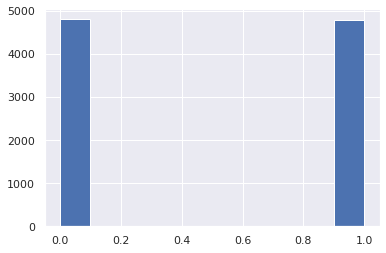

In [638]:
target_upsampled.hist()

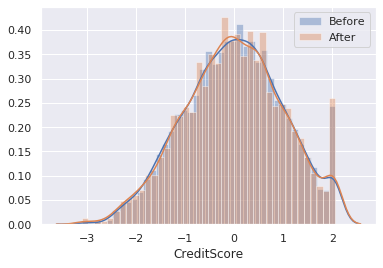

In [639]:
# Проверим, изменилось ли распределение после выравнивания баланса классов
sns.distplot(features['CreditScore'], label='Before')
sns.distplot(features_upsampled['CreditScore'], label="After")
plt.legend()

##### Видно, что распределения идентичны, значит, смещений не произошло

Найдём лучшие показатели случайного леса на новых данных

In [640]:
tree_model_upsapmling, tree_upsampling_score_max = tree_score(features_upsampled, target_upsampled, features_valid, target_valid)

,n_estim,depth,roc_auc,f1
70,100,11,0.769145,0.622322
69,100,10,0.770521,0.622074
54,80,11,0.769393,0.621773
35,60,8,0.779274,0.619689
67,100,8,0.777830,0.618750


#### Попробуем downsampling

In [641]:
def downsample(features, target):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    fraction = len(target_ones)/len(target_zeros)
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [642]:
features_downsampled, target_downsampled = downsample(features_train, target_train)

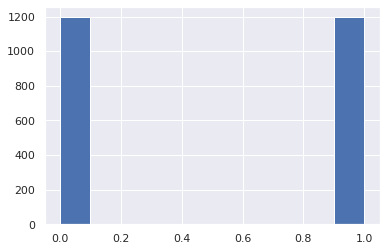

In [643]:
target_downsampled.hist()

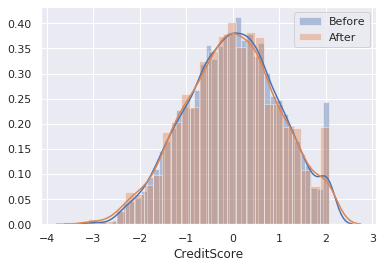

In [644]:
# Проверим, изменилось ли распределение после выравнивания баланса классов
sns.distplot(features['CreditScore'], label='Before')
sns.distplot(features_downsampled['CreditScore'], label="After")
plt.legend()

#### Видно, что распределения идентичны, значит, смещений не произошло

In [645]:
tree_model_downsampling, tree_downsampling_score_max = tree_score(features_downsampled, target_downsampled, features_valid, target_valid)

,n_estim,depth,roc_auc,f1
33,60,6,0.776245,0.602713
47,60,20,0.778681,0.602089
65,100,6,0.775613,0.601547
17,40,6,0.775545,0.600577
49,80,6,0.774280,0.598274


#### Сделаем таблицу с наилучшими результатами

In [646]:
score_stat = pd.DataFrame([tree_score_max, tree_downsampling_score_max, tree_upsampling_score_max], index=['no_balanced', 'downsampling', 'upsampling'])
score_stat.sort_values('f1', ascending=False)

,n_estim,depth,roc_auc,f1
upsampling,100.0,11.0,0.769145,0.622322
downsampling,60.0,6.0,0.776245,0.602713
no_balanced,100.0,17.0,0.725192,0.601190


#### Самый лучший результат дал upsampling, F1 = 0.622 > 0.59 (по требованию задания)
Исходя из этого лучшая модель - случайный лес с параметрами n_estimators=100, max_depth=11

# 4. Тестирование модели

#### Протестируем модель с лучшими параметрами на тестовой выборке

In [647]:
model = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=random_state)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_test)

In [648]:
print('roc_auc_score: {}\nf1_score: {}'.format(roc_auc_score(target_test,predicted_valid),f1_score(target_test,predicted_valid)))

roc_auc_score: 0.7584185191681245
f1_score: 0.6085011185682327
